### Importing libraries

In [20]:
import wget
import zipfile
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from Adaboost import *
from sklearn.ensemble import AdaBoostClassifier

### Spambase DataSet: 

Dataset containing 4601 emails that are labeled as either spam or not. Mostly features are word & symbol frequencies. The data is publicly available at the University of California, Irvine's Machine Learning repository. It can be downloaded in this link:
https://archive.ics.uci.edu/ml/datasets/spambase

In [21]:
zip_file = wget.download("https://archive.ics.uci.edu/static/public/94/spambase.zip")
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()
os.remove(zip_file)

### Reading the DataSet:

In [22]:
df = pd.read_csv('spambase.data', header = None)
names = pd.read_csv('spambase.names', sep = ':', skiprows=range(0, 33), header = None)
col_names = list(names[0])
col_names.append('Spam')
df.columns = col_names

#### Convert classes in target variable to {-1, 1}

In [23]:
df['Spam'] = df['Spam'] * 2 - 1
df['Spam'].unique()

array([ 1, -1], dtype=int64)

In [24]:
print('Shape of data:', df.shape)

Shape of data: (4601, 58)


#### Train - Test Split:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'Spam').values, df['Spam'].values, train_size = 3065, random_state = 2)

In [26]:
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Implementation of Adaboost Algorithm:

Setting: Classification ($y_i \in \{+1, -1\}$)

Weak learners: $h \in \mathcal{H}$ are binary, $h(x_i) \in \{-1, +1\}, \forall x$

Step-size: We perform line-search to obtain the best step-size $\alpha$

Loss function: Exponential loss $\mathcal{L}(H) = \sum_{i=1}^{n} e^{-y_i H(x_i)}$


1. Updating Weights:
        $$
                \hat{w}_i \leftarrow \hat{w_i}*e^{-\alpha h(\mathbf{x}_i)y_i}
        $$

In [27]:
def update_weights(w_i, alpha, y, h_x):
        """
        Update weights based on the error of the weak classifier.

        Args:
        w_i (array-like): Current weights.
        alpha (float): Alpha(Step-Size) calculated based on weighted classification error.
        y (array-like): True labels.
        h_x (array-like): Predicted labels.

        Returns:
        array-like: Updated weights.
        """
        return w_i * np.exp(alpha * (y != h_x).astype(int))

2. Step-Size(Alpha) Calculation:
$$
\alpha = \frac{1}{2} \ln \left( \frac{1-\epsilon}{\epsilon} \right), \text{where} \\
\quad \epsilon = \sum_{i:h(\mathbf{x}_i)y_i=-1} w_i \\
\quad \epsilon = \text{weighted-classification error}
$$


In [28]:
def calculate_alpha(error): 
        """
        Calculate alpha for updating weights in Adaboost.

        Formula:
        alpha = log((1 - error) / error)

        Args:
        error (float): The error rate of the weak classifier.

        Returns:
        float: The calculated alpha value.
        """
        return np.log((1 - error) / error)

3. Weighted-Classification Error Calculation:

In [29]:
def calculate_error(y, h_x, w_i):
        """
        Calculate the weighted error rate of the weak classifier.

        Formula:
        error = sum(w_i * (y != h_x)) / sum(w_i)

        Args:
        y (array-like): True labels.
        h_x (array-like): Predicted labels.
        w_i (array-like): Weights.

        Returns:
        float: Weighted error rate.
        """
        return (sum(w_i * (y != h_x).astype(int))) / sum(w_i)


In [45]:
class Adaboost:
    def __init__(self):
        self.alphas = []
        self.H_t = []
        self.t = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, t=400):
        self.alphas = [] 
        self.training_errors = []
        self.t = t

        for t in range(0, t):
            if t == 0:
                w_i = np.ones(len(y)) * 1 / len(y) # Initialize weights
            else:
                w_i = update_weights(w_i, alpha_m, y, h_x)
            
            H_t = DecisionTreeClassifier(max_depth=1)     # Stump: Two terminal-node classification tree
            H_t.fit(X, y, sample_weight=w_i)
            h_x = H_t.predict(X)

            self.H_t.append(H_t)

            error_m = calculate_error(y, h_x, w_i)
            self.training_errors.append(error_m)

            alpha_m = calculate_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.H_t) == len(self.alphas)

    def predict(self, X):
        weak_preds = pd.DataFrame(index=range(len(X)), columns=range(self.t)) 

        for t in range(self.t):
            h_x_m = self.H_t[t].predict(X) * self.alphas[t]
            weak_preds.iloc[:, t] = h_x_m

        h_x = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return h_x

    def error_rates(self, X, y):
        self.prediction_errors = [] # Clear before calling
        
        for t in range(self.t):
            h_x_m = self.H_t[t].predict(X)          
            error_m = calculate_error(y=y, h_x=h_x_m, w_i=np.ones(len(y)))
            self.prediction_errors.append(error_m)


$$

$$

In [31]:
ab = Adaboost()
ab.fit(X_train, y_train, t = 400)

In [32]:
# Predict on test set
y_pred = ab.predict(X_test)
print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred), 4))

The ROC-AUC score of the model is: 0.9399


In [33]:
ab_sk = AdaBoostClassifier(n_estimators = 400) 
ab_sk.fit(X_train, y_train)
y_pred_sk = ab_sk.predict(X_test)
print('The ROC-AUC score of the sk-learn model is:', round(roc_auc_score(y_test, y_pred_sk), 4))

c:\Users\up78c\miniconda3\envs\ds\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


The ROC-AUC score of the sk-learn model is: 0.9279


## Training Error:

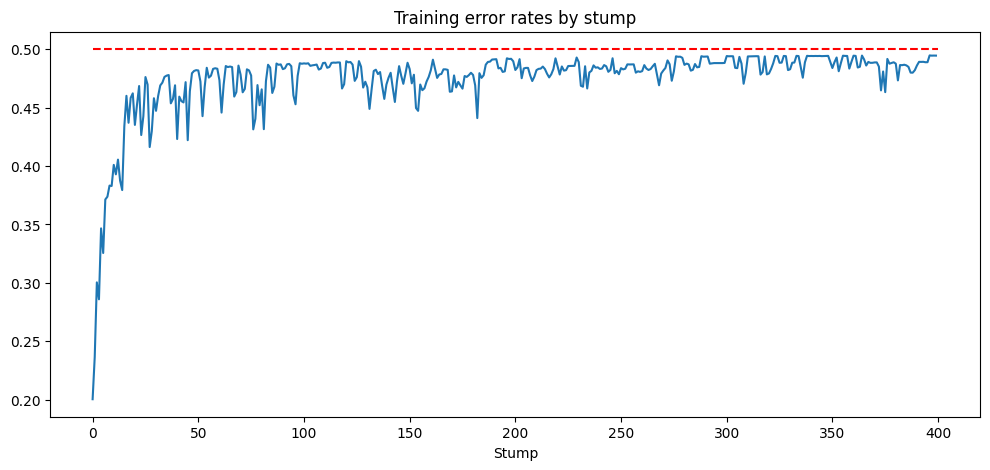

In [34]:
plt.figure(figsize=(12,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

In [35]:
def calculate_error(h_x, y, w_i):
    return (sum(w_i * (np.not_equal(y, h_x)).astype(int)))/sum(w_i)

In [36]:
print('Error rate:', round(calculate_error(y_test, y_pred, np.ones(len(y_test))), 4))

Error rate: 0.056


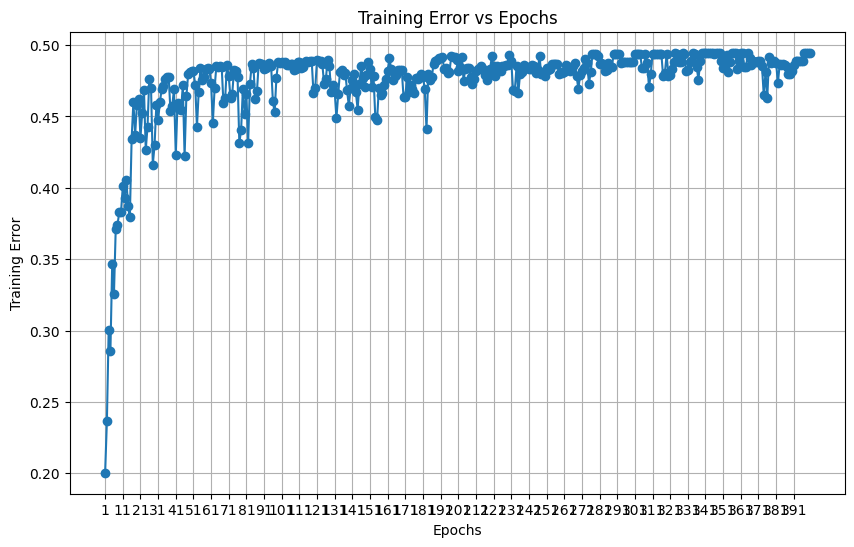

In [39]:
adaboost = Adaboost()
adaboost.fit(X_train, y_train)

# Collect training errors at each epoch
epochs = range(1, adaboost.t + 1)
training_errors = adaboost.training_errors

# Plot error vs epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_errors, marker='o', linestyle='-')
plt.title('Training Error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.grid(True)
plt.xticks(np.arange(1, adaboost.t + 1, 10))
plt.show()

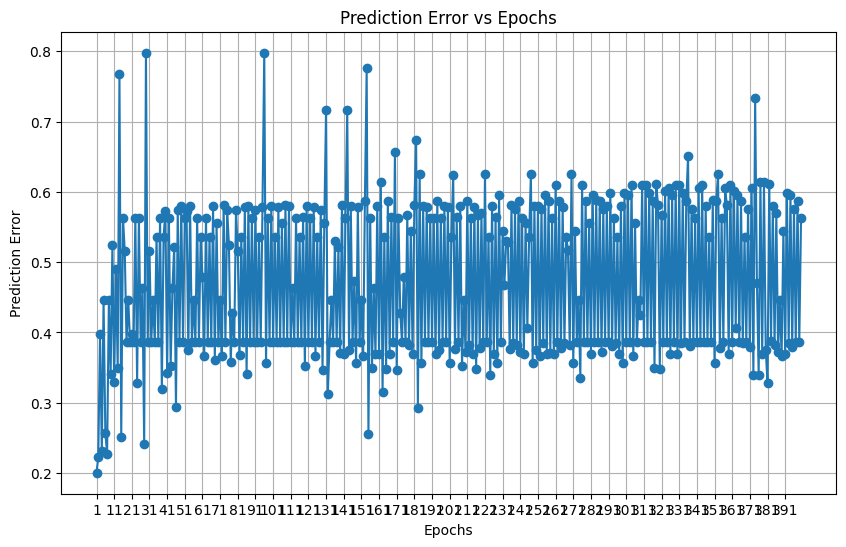

In [48]:
import numpy as np
import matplotlib.pyplot as plt

class Adaboost:
    def __init__(self):
        self.alphas = []
        self.H_t = []
        self.t = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, t=400):
        self.alphas = [] 
        self.training_errors = []
        self.t = t

        for epoch in range(1, t+1):  # Renaming variable to avoid conflict
            if epoch == 1:
                w_i = np.ones(len(y)) * 1 / len(y)  # Initialize weights
            else:
                w_i = self.update_weights(w_i, alpha_m, y, h_x)  # Fixing function call
            
            H_t = DecisionTreeClassifier(max_depth=1)
            H_t.fit(X, y, sample_weight=w_i)
            h_x = H_t.predict(X)

            self.H_t.append(H_t)

            error_m = self.calculate_error(y, h_x, w_i)  # Fixing function call
            self.training_errors.append(error_m)

            alpha_m = self.calculate_alpha(error_m)  # Fixing function call
            self.alphas.append(alpha_m)

        assert len(self.H_t) == len(self.alphas)

        # Calculate prediction errors
        self.prediction_errors = []
        for t in range(self.t):
            h_x_m = self.H_t[t].predict(X)          
            error_m = self.calculate_error(y=y, h_x=h_x_m, w_i=np.ones(len(y)))
            self.prediction_errors.append(error_m)

    def predict(self, X):
        weak_preds = pd.DataFrame(index=range(len(X)), columns=range(self.t)) 

        for t in range(self.t):
            h_x_m = self.H_t[t].predict(X) * self.alphas[t]
            weak_preds.iloc[:, t] = h_x_m

        h_x = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return h_x

    def calculate_alpha(self, error): 
        return np.log((1 - error) / error)

    def calculate_error(self, y, h_x, w_i):
        return (sum(w_i * (np.not_equal(y, h_x)).astype(int))) / sum(w_i)

    def update_weights(self, w_i, alpha, y, h_x):
        return w_i * np.exp(alpha * (np.not_equal(y, h_x)).astype(int))


# Assuming you have training data X_train and y_train
adaboost = Adaboost()
adaboost.fit(X_train, y_train)

# Collect prediction errors at each epoch
epochs = range(1, adaboost.t + 1)
prediction_errors = adaboost.prediction_errors

# Plot prediction error vs epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, prediction_errors, marker='o', linestyle='-')
plt.title('Prediction Error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.xticks(np.arange(1, adaboost.t + 1, 10))
plt.show()


In [47]:
prediction_errors

[]

In [ ]:

# Plot prediction error vs epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, prediction_errors, marker='o', linestyle='-')
plt.title('Prediction Error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.xticks(np.arange(1, adaboost.t + 1, 10))
plt.show()

## Refrences:
    1. https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote19.html

Step-Size Calculation Derivation:

$$
\begin{align}
\sum_{i=1}^{n} y_i h(\mathbf{x}_i) e^{-\left(y_i H(\mathbf{x}_i)+\alpha y_i h(\mathbf{x}_i)\right)}  &=0 
&& \Big(   y_ih(\mathbf{x}_i)\in\{+1,-1\}\Big)\\
-\sum_{i:h(\mathbf{x}_i) y_i=1} e^{-(y_i H(\mathbf{x}_i)+\alpha \underbrace{y_i h(\mathbf{x}_i)}_\mathrm{1})} + \sum_{i:h(\mathbf{x}_i) y_i = -1} e^{-(y_i H(\mathbf{x}_i)+\alpha \underbrace{y_i h(\mathbf{x}_i)}_\mathrm{-1})}&=0 
&& \Big(w_i= \frac{1}{Z}e^{-y_iH(\mathbf{x}_i)}\Big)\\
-\sum_{i:h(\mathbf{x}_i) y_i=1} w_i e^{-\alpha} + \sum_{i:h(\mathbf{x}_i) y_i = -1} w_i e^{\alpha}&=0 
&& \Big( \epsilon=\!\!\sum_{i:h(\mathbf{x}_i)y_i=-1} \!\!w_i \Big)\\
-(1-\epsilon)e^{-\alpha}+\epsilon e^{\alpha}&=0
&& \\
e^{2 \alpha}&=\frac{1-\epsilon}{\epsilon}\\
\alpha&=\frac{1}{2}\ln \frac{1-\epsilon}{\epsilon}\\
\end{align}
$$